<a href="https://colab.research.google.com/github/sagewoodard/EuroSAT_StableDiffusion/blob/main/SDM_11_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the EuroSAT dataset from Google Drive
from google.colab import drive
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive')
# Set the dataset path
data_dir = '/content/drive/MyDrive/EuroSAT/Forest'

IMG_SIZE = 256 # Size for stable diffusion
BATCH_SIZE = 1 # Process one image at a time for generation

# Load EuroSAT dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Normalize images for compatibility with stable diffusion
train_dataset = train_dataset.map(lambda x: (x / 127.5) - 1)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3000 files.


In [ ]:
# Load and configure the stable diffusion model
# Initialize the stable diffusion image-to-image pipeline
from diffusers import StableDiffusionImg2ImgPipeline
import torch

# Load stable diffusion image-to-image pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)

# Set the model to use the GPU
pipe = pipe.to('cuda') # This moves the model to the A100 GPU in Google Colab
print('Using GPU:', torch.cuda.get_device_name(0))

# Optionally disable the safety checker
pipe.safety_checker = None # Disable safety checker

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# Generate and display original and generated images
import numpy as np
from PIL import Image

# Function to generate an image using stable diffusion
def generate_image(original_image, strength=0.02, guidance_scale=2):
    prompt = "image"  # Neutral prompt to minimize changes
    original_image_pil = Image.fromarray((original_image * 255).astype(np.uint8))
    generated_image_pil = pipe(prompt=prompt, image=original_image_pil, strength=strength, guidance_scale=guidance_scale).images[0]
    return generated_image_pil

# Generate and store images
generated_images = []
original_images = []

for original_images_batch in train_dataset.take(16):  # Take 16 images from the dataset
    original_image = original_images_batch[0].numpy()
    generated_image = generate_image(original_image)

    # Store the original and generated images
    original_images.append(original_image)
    generated_images.append(np.array(generated_image))

# Convert images to arrays for easy display
original_images = [(img + 1) / 2 for img in original_images]  # Rescale to [0, 1] for display
generated_images = [img / 255.0 for img in generated_images]  # Ensure [0, 1] range for generated images

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

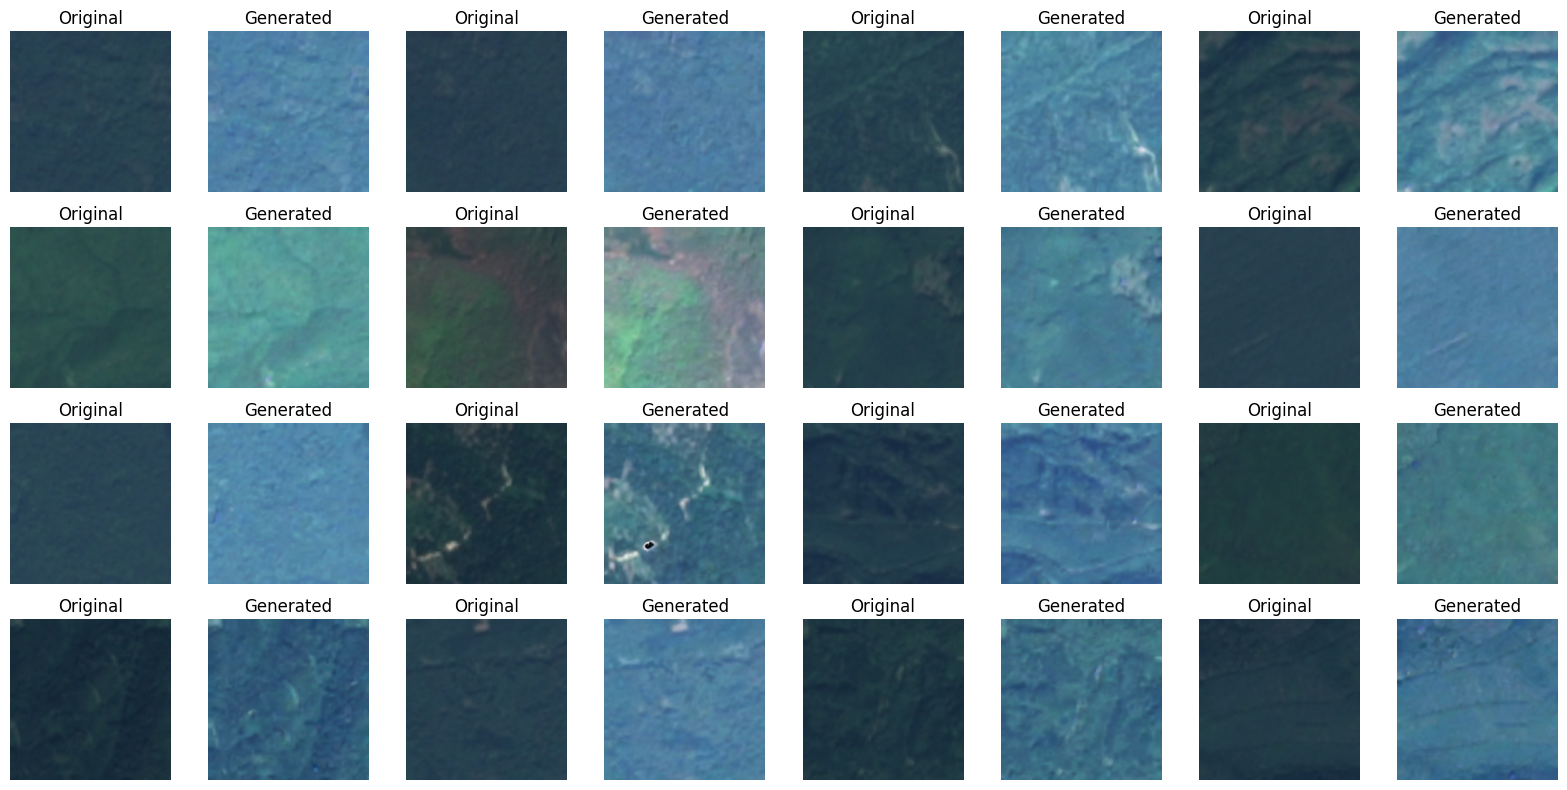

In [ ]:
# Display original and generated images
import matplotlib.pyplot as plt

# Plotting 16 images in a 4x8 grid for both original and generated images
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(16):
    # Original images on the left side (first 4 columns)
    axes[i // 4, (i % 4) * 2].imshow(original_images[i])
    axes[i // 4, (i % 4) * 2].axis("off")
    axes[i // 4, (i % 4) * 2].set_title("Original")

    # Generated images on the right side (next 4 columns)
    axes[i // 4, (i % 4) * 2 + 1].imshow(generated_images[i])
    axes[i // 4, (i % 4) * 2 + 1].axis("off")
    axes[i // 4, (i % 4) * 2 + 1].set_title("Generated")

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Frechet Inception Distance (FID)
from scipy.linalg import sqrtm

# Convert images to [0, 255] range for FID calculation
original_images_np = np.array([(img + 1) / 2 * 255.0 for img in original_images])  # Scale to [0, 255]
generated_images_np = np.array([img * 255.0 for img in generated_images])      # Scale to [0, 255]

# Load pre-trained InceptionV3 model for feature extraction
inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Function to preprocess images for InceptionV3
def preprocess_images(images):
    images = tf.image.resize(images, (299, 299))  # Resize to 299x299
    images = (images - 127.5) / 127.5  # Scale to [-1, 1]
    return images

# Function to calculate activations
def get_activations(images):
    images = preprocess_images(images)
    return inception_model.predict(images)

# Function to calculate the FID score
def calculate_fid(real_images, generated_images):
    act_real = get_activations(real_images)
    act_gen = get_activations(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate the difference in means
    mean_diff = np.sum((mu_real - mu_gen) ** 2)

    # Calculate the product of the covariances
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)

    # Check for imaginary values in covmean
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = mean_diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

# Calculate FID Score
fid_score = calculate_fid(original_images_np, generated_images_np)
print("FID Score:", fid_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
FID Score: 165.73935229494703
